<a href="https://colab.research.google.com/github/CodingDuckmx/AmazonKindleReviews/blob/master/Notebooks/Kindle_Reviews_v_C_0_2_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Info about the data set.

columns:


    asin - ID of the product, e.g. 0000031852
    vote - helpful votes of the review



# Import libraries section.

In [0]:
import joblib
import sklearn
import category_encoders as ce
import xgboost
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')


joblib==0.14.1
scikit-learn==0.22.1
category_encoders==2.1.0
xgboost==0.90


In [0]:
# !pip install category_encoders
# !pip install eli5

In [0]:
import os
import gzip
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from urllib.request import urlopen
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import pickle
from nltk.stem.snowball import SnowballStemmer
from textblob import TextBlob
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
import eli5
from eli5.sklearn import PermutationImportance
from joblib import dump
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from joblib import dump
from datetime import datetime
import matplotlib.dates as mdates

## Half fun half work
from IPython.display import Audio

# Area 501

###Get the data in the pickles

In [0]:
#  !wget https://www.dropbox.com/s/3vkpyfsuxhflix0/reviews_1_sample.pkl
#  !wget https://www.dropbox.com/s/bhl1na1mvzjgobf/reviews_2_sample.pkl
#  !wget https://www.dropbox.com/s/81t5c1ujo18s0bu/reviews_3_sample.pkl
#  !wget https://www.dropbox.com/s/5rx8bobtl6h7v6q/reviews_4_sample.pkl
#  !wget https://www.dropbox.com/s/3xzto7aei68dyxs/reviews_5_sample.pkl




In [0]:
reviews_1 = pd.read_pickle('reviews_1_sample.pkl')
reviews_2 = pd.read_pickle('reviews_2_sample.pkl')
reviews_3 = pd.read_pickle('reviews_3_sample.pkl')
reviews_4 = pd.read_pickle('reviews_4_sample.pkl')
reviews_5 = pd.read_pickle('reviews_5_sample.pkl')

In [0]:
reviews_1.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'reviewyear', 'reviewmonth', 'reviewday', 'season'],
      dtype='object')

In [0]:

def len_of_review(text):

  len_sum = len(text.split())
  return len_sum

lenreview = lambda x : len_of_review(x)  

In [0]:
###Sentimental Analysis

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity


In [0]:
def clean_numbers_signs(text):

  text = str(text)
  text = text.lower()
  text = re.sub('\[.*?\]','',text) ### get rid of the brackets
  text = re.sub('[%s]' % re.escape(string.punctuation),'',text)  ### get rid of punctation marks.
  text = re.sub('\w*\d\w*', '',text)  ##get rid of the numbers.
  


  return text

round1 = lambda x: clean_numbers_signs(x)

In [0]:
### I'm dropping reviewTime because it is the same as unixreviewTime.
### I'm dropping reviewerName because it is uniquely associated to the reviewerID.
### I'm filling the vote column missing values with zero.
### I'm just considering Kindle Books, so I'm dropping no-Kindle reviews.

def cleanning(dataframe):

  dataframe = dataframe.copy()  
  dataframe['overall'] = dataframe['overall'].astype(int)
  dataframe = dataframe.drop(labels=dataframe[dataframe['style'] != 'Kindle Edition'].index, axis=0)
  dataframe['summary'] = dataframe['summary'].apply(clean_numbers_signs)
  dataframe['len_summary'] = dataframe['summary'].apply(lenreview)
  dataframe['polarity_sum'] = dataframe['summary'].apply(pol)
  dataframe['subjectivity_sum'] = dataframe['summary'].apply(sub)
  dataframe['reviewText'] = dataframe['reviewText'].apply(clean_numbers_signs)
  dataframe['polarity_rT'] = dataframe['reviewText'].apply(pol)
  dataframe['subjectivity_rT'] = dataframe['reviewText'].apply(sub)  
  dataframe['len_reviewText'] = dataframe['reviewText'].apply(lenreview)
  dataframe['vote'] = dataframe['vote'].fillna(0)
  dataframe['vote'] = dataframe['vote'].astype(int)
  dataframe = dataframe.drop(columns=['reviewTime','reviewerName','style'])

  return dataframe



In [0]:

reviews_1 = cleanning(reviews_1)
reviews_2 = cleanning(reviews_2)
reviews_3 = cleanning(reviews_3)
reviews_4 = cleanning(reviews_4)
reviews_5 = cleanning(reviews_5)

In [0]:
reviews = pd.concat([reviews_1,reviews_2,reviews_3,reviews_4,reviews_5]).sort_values(by='unixReviewTime').reset_index(drop=True)
reviews

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,vote,image,reviewyear,reviewmonth,reviewday,season,len_summary,polarity_sum,subjectivity_sum,polarity_rT,subjectivity_rT,len_reviewText
0,5,False,A23ZNGL704AW7O,B00NN3DE5O,in a future world devoid of all men a civiliza...,klovers courtesy of kwips kritiques,1196467200,8,False,2007,12,1,winter,5,0.000000,0.000000,0.088510,0.417593,290
1,5,False,A23ZNGL704AW7O,B000R93E3E,with an abusive exhusband stalking her relentl...,klovers courtesy of kwips kritiques,1196467200,15,False,2007,12,1,winter,5,0.000000,0.000000,0.176840,0.491144,488
2,5,True,A14O0KGU3CI7Q1,B00C6MZ3WU,what a story if learning american history co...,if american history class had only been this good,1198108800,0,False,2007,12,20,winter,9,0.233333,0.533333,0.152778,0.478889,151
3,5,False,A2AY83K9N60V38,B0015YEQ8W,belle taylor has her life carefully mapped out...,delightful tale of hope and promise,1205884800,2,False,2008,3,19,spring,6,1.000000,1.000000,0.189686,0.507748,617
4,5,False,A23ZNGL704AW7O,B0015YEQ6O,its friday night again and hailey jennison joi...,klovers courtesy of kwips kritiques,1206230400,21,False,2008,3,23,spring,5,0.000000,0.000000,0.390659,0.606349,330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203874,4,True,A2BJ5C3HIB3IYJ,B01G7I876W,this regency mm romance between servants set o...,entertaining and sweet,1538265600,0,False,2018,9,30,autumn,3,0.425000,0.675000,0.135065,0.452597,229
203875,5,False,A3L9TMJW3EJRJE,B01GGCYJ16,\n\na short punchy exceedingly good novella\n...,excellent,1538352000,0,False,2018,10,1,autumn,1,1.000000,1.000000,0.366667,0.604167,87
203876,3,True,A3KIS3KIFSC6L,B01GWMFSYM,a very trying love story the worst things alw...,managing the bosses set,1538352000,0,False,2018,10,1,autumn,4,0.000000,0.000000,0.205385,0.569231,80
203877,4,True,A25NWP4OC6IKYH,B01HF1XN1Y,good story of a mature woman with teenagers wh...,abigail and milton,1538438400,0,False,2018,10,2,autumn,3,0.000000,0.000000,0.400000,0.575000,47


In [0]:
top50reviewers = pd.DataFrame(reviews['reviewerID'].value_counts(), index=reviews['reviewerID'].value_counts().index ).rename(columns=({'reviewerID':'number_of_reviews'})).sort_values(by='number_of_reviews',ascending=False).head(50)
top50reviewers 

,number_of_reviews
A1JLU5H1CCENWX,122
A328S9RN3U5M68,108
A2YJ8VP1SSHJ7,97
A3GWE80SUGORJD,90
A13QTZ8CIMHHG4,86
A2VXSQHJWZAQGY,86
A1V4LZS4HHHH6K,85
AG63N054UPJH2,85
A2UNMDJYXPEQZ3,82
A2Z3DQ7P9JYRLG,81


In [0]:
top50reviewed = pd.DataFrame(reviews['asin'].value_counts(), index=reviews['asin'].value_counts().index ).rename(columns=({'asin':'number_of_reviews'})).sort_values(by='number_of_reviews',ascending=False).head(50)
top50reviewed



,number_of_reviews
B00YN6XHMU,203
B00C2WDD5I,134
B00ESJ3S94,129
B00LD6IYUS,78
B00ABLJ5X6,78
B0142IHZPI,76
B00WGXCP1G,76
B00XIHMD2K,72
B00IJYII4E,72
B01A1E8WO0,67


In [0]:
top50voted = reviews[['reviewerID','vote']].groupby(['reviewerID']).sum().sort_values(by='vote',ascending=False).head(50)
top50voted





,vote
reviewerID,
A2AIE9DO5QSVBD,413
ARIDN94LOCQFD,411
A2UNMDJYXPEQZ3,408
AO16D5VV91API,378
A2G5IFYYHFIQNB,358
A2VXSQHJWZAQGY,352
A328S9RN3U5M68,302
A3IB13DLDST4TL,283
A2WFJGM6UCXWRF,274


In [0]:
def is_in_the_top_1(dataframe):

  for i in range(len(reviews)):
    if dataframe.loc[i,'asin'] in top50reviewers.index:
      dataframe.loc[i,'reviewedTop50'] = True
    else:
      dataframe.loc[i,'reviewedTop50'] = False

  return dataframe

In [0]:
def is_in_the_top_2(dataframe):

    for i in range(len(reviews)):
      if dataframe.loc[i,'reviewerID'] in top50reviewers.index:
        dataframe.loc[i,'reviewerTop50'] = True
      else:
        dataframe.loc[i,'reviewerTop50'] = False
    return dataframe

In [0]:
def is_in_the_top_3(dataframe):

  for i in range(len(reviews)):

    if dataframe.loc[i,'vote'] in top50voted.index:
      dataframe.loc[i,'votedTop50'] = True
    else:
      dataframe.loc[i,'votedTop50'] = False    


  return dataframe

In [0]:
###  Optional, this not improve the accuracy.
# reviews = is_in_the_top_1(reviews)

In [0]:
# reviews = is_in_the_top_2(reviews)

In [0]:
###  Optional, this not improve the accuracy.
# reviews = is_in_the_top_3(reviews)
reviews

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,vote,image,reviewyear,reviewmonth,reviewday,season,len_summary,polarity_sum,subjectivity_sum,polarity_rT,subjectivity_rT,len_reviewText
0,5,False,A23ZNGL704AW7O,B00NN3DE5O,in a future world devoid of all men a civiliza...,klovers courtesy of kwips kritiques,1196467200,8,False,2007,12,1,winter,5,0.000000,0.000000,0.088510,0.417593,290
1,5,False,A23ZNGL704AW7O,B000R93E3E,with an abusive exhusband stalking her relentl...,klovers courtesy of kwips kritiques,1196467200,15,False,2007,12,1,winter,5,0.000000,0.000000,0.176840,0.491144,488
2,5,True,A14O0KGU3CI7Q1,B00C6MZ3WU,what a story if learning american history co...,if american history class had only been this good,1198108800,0,False,2007,12,20,winter,9,0.233333,0.533333,0.152778,0.478889,151
3,5,False,A2AY83K9N60V38,B0015YEQ8W,belle taylor has her life carefully mapped out...,delightful tale of hope and promise,1205884800,2,False,2008,3,19,spring,6,1.000000,1.000000,0.189686,0.507748,617
4,5,False,A23ZNGL704AW7O,B0015YEQ6O,its friday night again and hailey jennison joi...,klovers courtesy of kwips kritiques,1206230400,21,False,2008,3,23,spring,5,0.000000,0.000000,0.390659,0.606349,330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203874,4,True,A2BJ5C3HIB3IYJ,B01G7I876W,this regency mm romance between servants set o...,entertaining and sweet,1538265600,0,False,2018,9,30,autumn,3,0.425000,0.675000,0.135065,0.452597,229
203875,5,False,A3L9TMJW3EJRJE,B01GGCYJ16,\n\na short punchy exceedingly good novella\n...,excellent,1538352000,0,False,2018,10,1,autumn,1,1.000000,1.000000,0.366667,0.604167,87
203876,3,True,A3KIS3KIFSC6L,B01GWMFSYM,a very trying love story the worst things alw...,managing the bosses set,1538352000,0,False,2018,10,1,autumn,4,0.000000,0.000000,0.205385,0.569231,80
203877,4,True,A25NWP4OC6IKYH,B01HF1XN1Y,good story of a mature woman with teenagers wh...,abigail and milton,1538438400,0,False,2018,10,2,autumn,3,0.000000,0.000000,0.400000,0.575000,47


In [0]:
reviews = reviews.reset_index()
reviews = reviews.rename(columns={'index':'reviewID'})
reviews

,reviewID,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,vote,image,reviewyear,reviewmonth,reviewday,season,len_summary,polarity_sum,subjectivity_sum,polarity_rT,subjectivity_rT,len_reviewText
0,0,5,False,A23ZNGL704AW7O,B00NN3DE5O,in a future world devoid of all men a civiliza...,klovers courtesy of kwips kritiques,1196467200,8,False,2007,12,1,winter,5,0.000000,0.000000,0.088510,0.417593,290
1,1,5,False,A23ZNGL704AW7O,B000R93E3E,with an abusive exhusband stalking her relentl...,klovers courtesy of kwips kritiques,1196467200,15,False,2007,12,1,winter,5,0.000000,0.000000,0.176840,0.491144,488
2,2,5,True,A14O0KGU3CI7Q1,B00C6MZ3WU,what a story if learning american history co...,if american history class had only been this good,1198108800,0,False,2007,12,20,winter,9,0.233333,0.533333,0.152778,0.478889,151
3,3,5,False,A2AY83K9N60V38,B0015YEQ8W,belle taylor has her life carefully mapped out...,delightful tale of hope and promise,1205884800,2,False,2008,3,19,spring,6,1.000000,1.000000,0.189686,0.507748,617
4,4,5,False,A23ZNGL704AW7O,B0015YEQ6O,its friday night again and hailey jennison joi...,klovers courtesy of kwips kritiques,1206230400,21,False,2008,3,23,spring,5,0.000000,0.000000,0.390659,0.606349,330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203874,203874,4,True,A2BJ5C3HIB3IYJ,B01G7I876W,this regency mm romance between servants set o...,entertaining and sweet,1538265600,0,False,2018,9,30,autumn,3,0.425000,0.675000,0.135065,0.452597,229
203875,203875,5,False,A3L9TMJW3EJRJE,B01GGCYJ16,\n\na short punchy exceedingly good novella\n...,excellent,1538352000,0,False,2018,10,1,autumn,1,1.000000,1.000000,0.366667,0.604167,87
203876,203876,3,True,A3KIS3KIFSC6L,B01GWMFSYM,a very trying love story the worst things alw...,managing the bosses set,1538352000,0,False,2018,10,1,autumn,4,0.000000,0.000000,0.205385,0.569231,80
203877,203877,4,True,A25NWP4OC6IKYH,B01HF1XN1Y,good story of a mature woman with teenagers wh...,abigail and milton,1538438400,0,False,2018,10,2,autumn,3,0.000000,0.000000,0.400000,0.575000,47


In [0]:
reviews.columns

Index(['reviewID', 'overall', 'verified', 'reviewerID', 'asin', 'reviewText',
       'summary', 'unixReviewTime', 'vote', 'image', 'reviewyear',
       'reviewmonth', 'reviewday', 'season', 'len_summary', 'polarity_sum',
       'subjectivity_sum', 'polarity_rT', 'subjectivity_rT', 'len_reviewText'],
      dtype='object')

In [0]:
print('How the scores are distributed, in the final data set?')

print(reviews['overall'].value_counts(normalize=True))

How the scores are distributed, in the final data set?
5    0.606433
4    0.253126
3    0.088788
2    0.030361
1    0.021292
Name: overall, dtype: float64


In [0]:
# reviews.to_pickle('reviews_base.pkl')

Dividing (and saving to pickles) by score.

In [0]:

reviews_score_1 = reviews[reviews['overall'] == 1].loc[:,:]
# reviews_score_1.to_pickle('reviews_score_1.pkl')

reviews_score_2 = reviews[reviews['overall'] == 2].loc[:,:]
# reviews_score_2.to_pickle('reviews_score_2.pkl')

reviews_score_3 = reviews[reviews['overall'] == 3].loc[:,:]
# reviews_score_3.to_pickle('reviews_score_3.pkl')

reviews_score_4_part1 = reviews[reviews['overall'] == 4].loc[0:19999,:]
# reviews_score_4_part1.to_pickle('reviews_score_4_part1.pkl')
reviews_score_4_part2 = reviews[reviews['overall'] == 4].loc[20000:39999,:]
# reviews_score_4_part2.to_pickle('reviews_score_4_part2.pkl')
reviews_score_4_part3 = reviews[reviews['overall'] == 4].loc[40000:,:]
# reviews_score_4_part3.to_pickle('reviews_score_4_part3.pkl')

reviews_score_5_part1 = reviews[reviews['overall'] == 5].loc[0:19999,:]
# reviews_score_5_part1.to_pickle('reviews_score_5_part1.pkl')
reviews_score_5_part2 = reviews[reviews['overall'] == 5].loc[20000:39999,:]
# reviews_score_5_part2.to_pickle('reviews_score_5_part2.pkl')
reviews_score_5_part3 = reviews[reviews['overall'] == 5].loc[40000:59999,:]
# reviews_score_5_part3.to_pickle('reviews_score_5_part3.pkl')
reviews_score_5_part4 = reviews[reviews['overall'] == 5].loc[60000:79999,:]
# reviews_score_5_part4.to_pickle('reviews_score_5_part4.pkl')
reviews_score_5_part5 = reviews[reviews['overall'] == 5].loc[80000:99999,:]
# reviews_score_5_part5.to_pickle('reviews_score_5_part5.pkl')
reviews_score_5_part6 = reviews[reviews['overall'] == 5].loc[100000:119999,:]
# reviews_score_5_part6.to_pickle('reviews_score_5_part6.pkl')
reviews_score_5_part7 = reviews[reviews['overall'] == 5].loc[120000:,:]
# reviews_score_5_part7.to_pickle('reviews_score_5_part7.pkl')


###Getting the TFIDF matrix

In [0]:
### Tokenization  of text

def tokenization(text):

  tv = TfidfVectorizer(stop_words='english', lowercase=False)
  data_tv = tv.fit_transform(text.summary)
  data_dtm = pd.DataFrame(data_tv.toarray(), columns= tv.get_feature_names())

  return data_dtm

In [0]:
tokenized_summary_1 = tokenization(reviews_score_1)

tokenized_summary_2 = tokenization(reviews_score_2)

tokenized_summary_3 = tokenization(reviews_score_3)

tokenized_summary_4_part1 = tokenization(reviews_score_4_part1)

tokenized_summary_4_part2 = tokenization(reviews_score_4_part2)

tokenized_summary_4_part3 = tokenization(reviews_score_4_part3)


In [0]:
tokenized_summary_5_part1 = tokenization(reviews_score_5_part1)

tokenized_summary_5_part2 = tokenization(reviews_score_5_part2)

tokenized_summary_5_part3 = tokenization(reviews_score_5_part3)

tokenized_summary_5_part4 = tokenization(reviews_score_5_part4)

tokenized_summary_5_part5 = tokenization(reviews_score_5_part5)

tokenized_summary_5_part6 = tokenization(reviews_score_5_part6)

tokenized_summary_5_part7 = tokenization(reviews_score_5_part7)

Getting rid of the mentioned words in less than the 0.01% of the reviews.

In [0]:
###  Define a function to get rid of the words not used in at least 0.01% of the reviews.

def get_rid_uncommon_words(text):
    most_common_words = (text.sum().sort_values())[(text.sum().sort_values()> len(text)*.001).values.tolist()].index.tolist()
    tokenized_summary = text[most_common_words]
    return tokenized_summary

In [0]:
tokenized_summary_1 = get_rid_uncommon_words(tokenized_summary_1)
tokenized_summary_2 = get_rid_uncommon_words(tokenized_summary_2)
tokenized_summary_3 = get_rid_uncommon_words(tokenized_summary_3)


In [0]:
tokenized_summary_4_part1 = get_rid_uncommon_words(tokenized_summary_4_part1)
tokenized_summary_4_part2 = get_rid_uncommon_words(tokenized_summary_4_part2)
tokenized_summary_4_part3 = get_rid_uncommon_words(tokenized_summary_4_part3)

In [0]:
tokenized_summary_5_part1 = get_rid_uncommon_words(tokenized_summary_5_part1)
tokenized_summary_5_part2 = get_rid_uncommon_words(tokenized_summary_5_part2)
tokenized_summary_5_part3 = get_rid_uncommon_words(tokenized_summary_5_part3)

In [0]:
tokenized_summary_5_part4 = get_rid_uncommon_words(tokenized_summary_5_part4)
tokenized_summary_5_part5 = get_rid_uncommon_words(tokenized_summary_5_part5)
tokenized_summary_5_part6 = get_rid_uncommon_words(tokenized_summary_5_part6)
tokenized_summary_5_part7 = get_rid_uncommon_words(tokenized_summary_5_part7)

In [0]:
reviews_score_1 = pd.concat([reviews_score_1.reset_index(drop=True),tokenized_summary_1],axis=1,join='inner')
reviews_score_2 = pd.concat([reviews_score_2.reset_index(drop=True),tokenized_summary_2],axis=1,join='inner')
reviews_score_3 = pd.concat([reviews_score_3.reset_index(drop=True),tokenized_summary_3],axis=1,join='inner')

In [0]:
reviews_score_4_part1 = pd.concat([reviews_score_4_part1.reset_index(drop=True),tokenized_summary_4_part1],axis=1,join='inner')
reviews_score_4_part2 = pd.concat([reviews_score_4_part2.reset_index(drop=True),tokenized_summary_4_part2],axis=1,join='inner')
reviews_score_4_part3 = pd.concat([reviews_score_4_part3.reset_index(drop=True),tokenized_summary_4_part3],axis=1,join='inner')

In [0]:
reviews_score_5_part1 = pd.concat([reviews_score_5_part1.reset_index(drop=True),tokenized_summary_5_part1],axis=1,join='inner')
reviews_score_5_part2 = pd.concat([reviews_score_5_part2.reset_index(drop=True),tokenized_summary_5_part2],axis=1,join='inner')
reviews_score_5_part3  = pd.concat([reviews_score_5_part3.reset_index(drop=True),tokenized_summary_5_part3],axis=1,join='inner')
reviews_score_5_part4  = pd.concat([reviews_score_5_part4.reset_index(drop=True),tokenized_summary_5_part4],axis=1,join='inner')
reviews_score_5_part5  = pd.concat([reviews_score_5_part5.reset_index(drop=True),tokenized_summary_5_part5],axis=1,join='inner')
reviews_score_5_part6  = pd.concat([reviews_score_5_part6.reset_index(drop=True),tokenized_summary_5_part6],axis=1,join='inner')
reviews_score_5_part7  = pd.concat([reviews_score_5_part7.reset_index(drop=True),tokenized_summary_5_part7],axis=1,join='inner')


In [0]:
reviews_score_4_part1.shape, reviews_score_4_part2.shape, reviews_score_4_part3.shape

((5538, 210), (5193, 214), (40876, 200))

In [0]:
reviews_score_4_part1_2 = pd.concat(list(reviews_score_4_part1.align(reviews_score_4_part2,axis=1)), ignore_index=True)
reviews_score_4 = pd.concat(list(reviews_score_4_part1_2.align(reviews_score_4_part3,axis=1)), ignore_index=True)
reviews_score_4

,action,addition,adorable,adventure,alpha,amazing,asin,author,awesome,bad,bdsm,bear,beautiful,beginning,best,better,bit,book,books,bride,chance,character,characters,charming,christmas,classic,clean,cliffhanger,collection,come,compelling,conclusion,contemporary,continuation,continues,cowboy,cozy,crazy,cute,dark,...,suspense,suspenseful,sweet,tale,think,thought,thriller,time,tips,totally,touching,trilogy,true,twist,twists,unexpected,unique,unixReviewTime,vampire,verified,vote,wait,want,wanted,wanting,way,wellwritten,western,wild,winner,wish,wonderful,world,worth,wow,writing,written,wrong,ya,zombie
0,0.0,0.0,NaN,0.0,0.0,0.0,B0012W11BM,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,NaN,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1210118400,0.0,False,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
1,0.0,0.0,NaN,0.0,0.0,0.0,B0012W11BM,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,NaN,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1212451200,0.0,False,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2,0.0,0.0,NaN,0.0,0.0,0.0,B001GIPJ2Y,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,NaN,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1236297600,0.0,True,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
3,0.0,0.0,NaN,0.0,0.0,0.0,B001TJ1O4W,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,NaN,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1238803200,0.0,True,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
4,0.0,0.0,NaN,0.0,0.0,0.0,B001VLXME8,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.497103,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,NaN,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1242172800,0.0,False,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51602,0.0,0.0,NaN,0.0,0.0,0.0,B01H2Z5X8Y,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1537660800,NaN,True,0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
51603,0.0,0.0,NaN,0.0,0.0,0.0,B01EYW7SAE,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1538006400,NaN,False,0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
51604,0.0,0.0,NaN,0.0,0.0,0.0,B01G7I876W,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.6034,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1538265600,NaN,True,0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
51605,0.0,0.0,NaN,0.0,0.0,0.0,B01HF1XN1Y,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1538438400,NaN,True,0,0.0,0.0,NaN,NaN,0.0,Na

In [0]:
reviews_score_4.columns[reviews_score_4.columns.duplicated()]

Index(['overall'], dtype='object')

In [0]:
# reviews_score_4 = pd.concat([reviews_score_4_part1,reviews_score_4_part2,reviews_score_4_part3],axis=0,join='outer',sort=False)

In [0]:
reviews_score_5 = pd.concat([reviews_score_5_part1,reviews_score_5_part2,reviews_score_5_part3,reviews_score_5_part4,reviews_score_5_part5,reviews_score_5_part6,reviews_score_5_part7],axis=0,join='outer',sort=False)


In [0]:
reviews_score_1.shape ,reviews_score_2.shape, reviews_score_3.shape ,reviews_score_4.shape ,reviews_score_5.shape

((4341, 251), (6190, 235), (18102, 194), (51607, 280), (123639, 273))

In [0]:
# processed_reviews = pd.concat([reviews_score_1,reviews_score_2, reviews_score_3,reviews_score_4,reviews_score_5],axis=0,join='outer',sort=False)
reviews_1_2 = pd.concat(list(reviews_score_1.align(reviews_score_2,axis=1)), ignore_index=True)
reviews_1_3 = pd.concat(list(reviews_1_2.align(reviews_score_3,axis=1)), ignore_index=True)
reviews_1_4 = pd.concat(list(reviews_1_3.align(reviews_score_4,axis=1)), ignore_index=True)
processed_reviews = pd.concat(list(reviews_1_4.align(reviews_score_5,axis=1)), ignore_index=True)
processed_reviews = processed_reviews.reset_index(drop=True)
processed_reviews.shape

(203879, 514)

In [0]:
processed_reviews = processed_reviews.iloc[:,~processed_reviews.columns.duplicated()]

In [0]:
#### Filling nans with zeros, for all columns except nan column

processed_reviews[processed_reviews.columns.drop('nan')] = processed_reviews[processed_reviews.columns.drop('nan')].fillna(0)

### Filling with True values where nan column is not null.

processed_reviews['nan'] = processed_reviews['nan'].fillna(False)
processed_reviews['nan'] = processed_reviews['nan'].replace(0,True)
processed_reviews = processed_reviews.drop(columns=['reviewID','reviewText','summary'])


In [0]:
processed_reviews.to_pickle('processed_reviews.pkl')

In [0]:
processed_reviews.shape

(203879, 508)

In [0]:
reviews.columns

Index(['reviewID', 'overall', 'verified', 'reviewerID', 'asin', 'reviewText',
       'summary', 'unixReviewTime', 'vote', 'image', 'reviewyear',
       'reviewmonth', 'reviewday', 'season', 'len_summary', 'polarity_sum',
       'subjectivity_sum', 'polarity_rT', 'subjectivity_rT', 'len_reviewText'],
      dtype='object')

In [0]:
### Ordering the columns

cols = list(processed_reviews.columns.values)
word_cols = list( set(processed_reviews.columns) - set(reviews.columns.drop(['reviewID', 'summary', 'reviewText'])))
processed_reviews = processed_reviews[ list(reviews.columns.drop(['reviewID', 'summary', 'reviewText'])) + word_cols]


## Visualizations

In [0]:
processed_reviews

,overall,verified,reviewerID,asin,unixReviewTime,vote,image,reviewyear,reviewmonth,reviewday,season,len_summary,polarity_sum,subjectivity_sum,polarity_rT,subjectivity_rT,len_reviewText,charming,worst,best,missing,repetitive,reviews,finding,concept,set,substance,hard,surprising,reads,strong,bother,rushed,decent,resource,easy,fabulous,heartwarming,ive,ripoff,...,fun,looking,real,try,continuation,line,extremely,fiction,like,novella,spoilers,wild,thoroughly,isnt,wanted,feel,sexy,info,second,im,started,recommend,serial,world,break,yuck,interesting,execution,simple,wtf,sweet,sizzling,western,mc,follow,surprise,shallow,bored,thrilling,ended
0,1,False,A3S3BCBT6LSV88,B001QIGZY0,1243814400,0,False,2009,6,1,summer,1,0.000000,0.000000,-0.108333,0.175000,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,True,A3OC8ZG1S3OAVA,B0015Z7VFQ,1257811200,6,False,2009,11,10,autumn,8,0.700000,0.600000,0.160370,0.740212,191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,False,AQDCGFHJJIWJI,B0030CMLUC,1269734400,5,False,2010,3,28,spring,5,0.600000,0.900000,0.003788,0.597727,106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.624715,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,True,A27S9RO1R8V1LG,B003A7I2JG,1270252800,2,False,2010,4,3,spring,4,-0.150000,0.100000,-0.116667,0.225000,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,True,A31MKOAROY68W8,B017A11MSU,1280188800,0,False,2010,7,27,summer,10,0.000000,0.000000,0.150000,0.675000,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203874,5,True,A37H1SC3HG545F,B01F0JKNWA,1538092800,0,False,2018,9,28,autumn,1,0.000000,0.000000,0.080000,0.550000,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203875,5,True,A1TZ2IHQRQ33TL,B01GQW4UQ0,1538179200,0,False,2018,9,29,autumn,9,0.125000,0.675000,-0.100000,0.400000,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203876,5,True,A1LZJKM7ENF9GJ,B01GAUZ8SM,1538265600,0,False,2018,9,30,autumn,13,0.178194,0.592639,0.185056,0.644611,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.482797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000

In [0]:
datetime.fromtimestamp(int('1243814400')).strftime('%Y-%m-%d %H:%M:%S')

np.array(pd.to_datetime(processed_reviews['unixReviewTime'], unit='s'))

fake = processed_reviews[['overall','verified','vote','len_reviewText','polarity_rT','subjectivity_rT']]
fake['date'] = np.array(pd.to_datetime(processed_reviews['unixReviewTime'], unit='s'))

start = datetime(2007,7,1)
end = datetime(2019,7,1)
fake

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,overall,verified,vote,len_reviewText,polarity_rT,subjectivity_rT,date
0,1,False,0,40,-0.108333,0.175000,2009-06-01
1,1,True,6,191,0.160370,0.740212,2009-11-10
2,1,False,5,106,0.003788,0.597727,2010-03-28
3,1,True,2,44,-0.116667,0.225000,2010-04-03
4,1,True,0,23,0.150000,0.675000,2010-07-27
...,...,...,...,...,...,...,...
203874,5,True,0,25,0.080000,0.550000,2018-09-28
203875,5,True,0,30,-0.100000,0.400000,2018-09-29
203876,5,True,0,22,0.185056,0.644611,2018-09-30
203877,5,False,0,96,0.458988,0.540909,2018-09-30


<function matplotlib.pyplot.show>

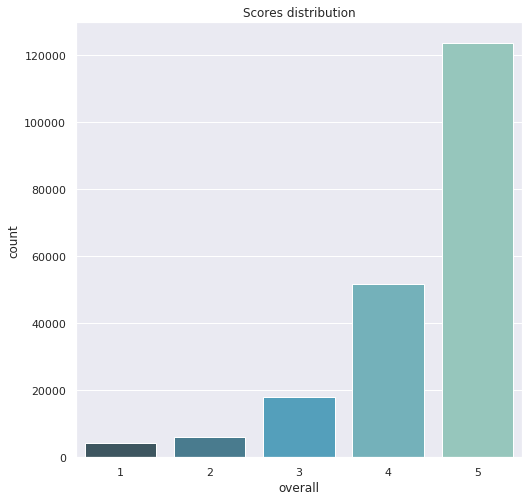

In [0]:
plt.figure(figsize=(8,8))
sns.countplot(x='overall', data=processed_reviews, palette='GnBu_d')
plt.title('Scores distribution')
plt.show

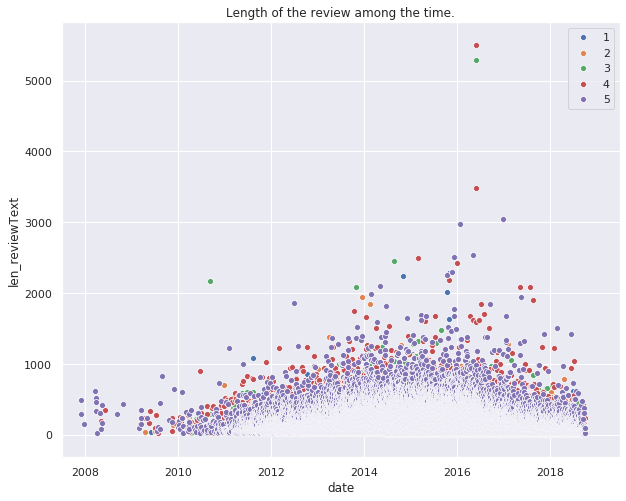

In [0]:
sns.set()

plt.figure(figsize=(10,8))
ax = sns.scatterplot(x='date',y='len_reviewText',  data=fake[fake['overall']== 1], label=1)
ax = sns.scatterplot(x='date',y='len_reviewText',  data=fake[fake['overall']== 2], label=2)
ax = sns.scatterplot(x='date',y='len_reviewText',  data=fake[fake['overall']== 3], label=3)
ax = sns.scatterplot(x='date',y='len_reviewText',  data=fake[fake['overall']== 4], label=4)
ax = sns.scatterplot(x='date',y='len_reviewText',  data=fake[fake['overall']== 5], label=5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(start, end)
plt.title('Length of the review among the time.')

plt.show()

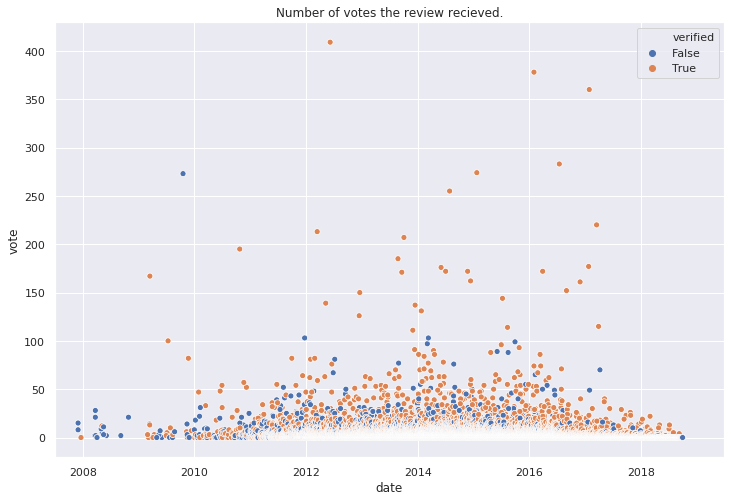

In [0]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='date',y='vote', hue='verified', data=fake)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(start, end)
plt.title('Number of votes the review recieved.')

plt.show()

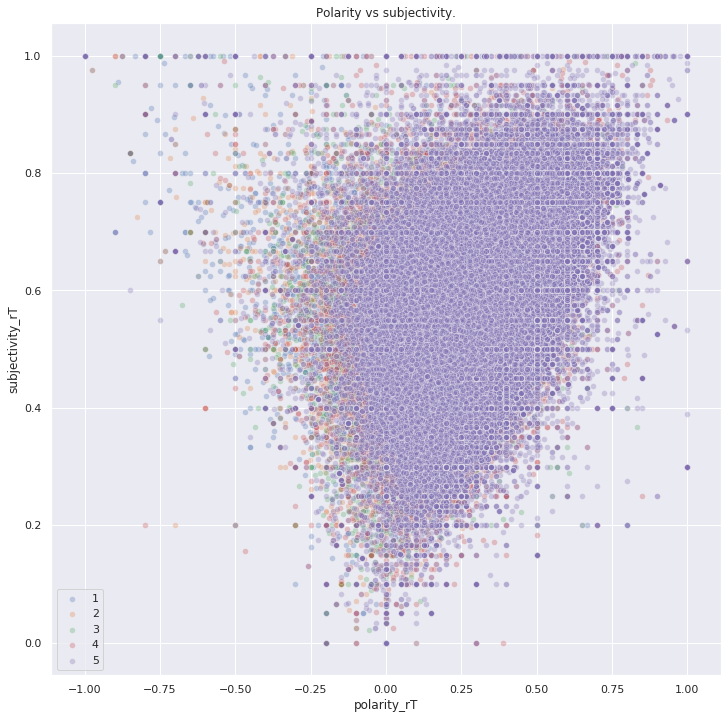

In [0]:
plt.figure(figsize=(12,12))
sns.scatterplot(x='polarity_rT',y='subjectivity_rT', alpha=0.3, data=fake[fake['overall']==1],label = 1)
sns.scatterplot(x='polarity_rT',y='subjectivity_rT', alpha=0.3, data=fake[fake['overall']==2],label = 2)
sns.scatterplot(x='polarity_rT',y='subjectivity_rT',alpha=0.3,  data=fake[fake['overall']==3],label = 3)
sns.scatterplot(x='polarity_rT',y='subjectivity_rT', alpha=0.3, data=fake[fake['overall']==4],label = 4)
sns.scatterplot(x='polarity_rT',y='subjectivity_rT', alpha=0.3, data=fake[fake['overall']==5],label = 5)

plt.title('Polarity vs subjectivity.')

plt.show()

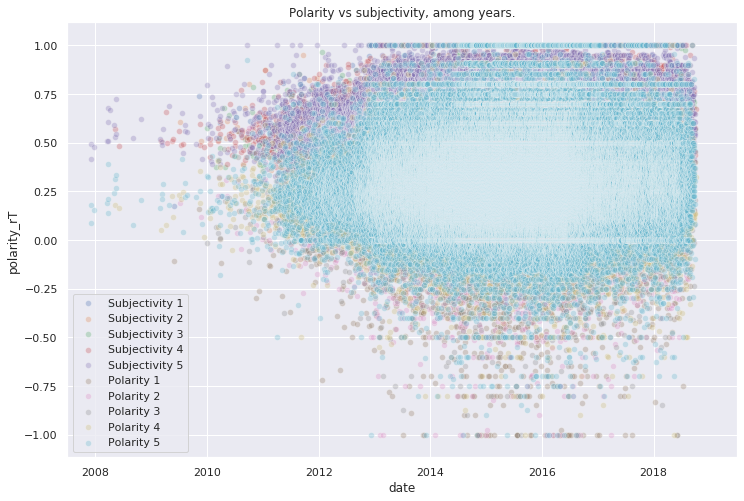

In [0]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='date',y='subjectivity_rT', alpha=0.3, data=fake[fake['overall']==1],label = 'Subjectivity 1')
sns.scatterplot(x='date',y='subjectivity_rT', alpha=0.3, data=fake[fake['overall']==2],label = 'Subjectivity 2')
sns.scatterplot(x='date',y='subjectivity_rT',alpha=0.3,  data=fake[fake['overall']==3],label = 'Subjectivity 3')
sns.scatterplot(x='date',y='subjectivity_rT', alpha=0.3, data=fake[fake['overall']==4],label = 'Subjectivity 4')
sns.scatterplot(x='date',y='subjectivity_rT', alpha=0.3, data=fake[fake['overall']==5],label = 'Subjectivity 5')
sns.scatterplot(x='date',y='polarity_rT', alpha=0.3, data=fake[fake['overall']==1],label = 'Polarity 1')
sns.scatterplot(x='date',y='polarity_rT', alpha=0.3, data=fake[fake['overall']==2],label = 'Polarity 2')
sns.scatterplot(x='date',y='polarity_rT',alpha=0.3,  data=fake[fake['overall']==3],label = 'Polarity 3')
sns.scatterplot(x='date',y='polarity_rT', alpha=0.3, data=fake[fake['overall']==4],label = 'Polarity 4')
sns.scatterplot(x='date',y='polarity_rT', alpha=0.3, data=fake[fake['overall']==5],label = 'Polarity 5')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(start, end)
plt.title('Polarity vs subjectivity, among years.')

plt.show()

In [0]:
words = processed_reviews.loc[:,word_cols].drop(columns='nan')

In [0]:
weight_words = pd.DataFrame(words.mean(),columns=['weight']).sort_values(by='weight',ascending=False)
top50_weight_words = weight_words.head(50)

In [0]:
top50_weight_words = top50_weight_words.reset_index(drop=False)
top50_weight_words

,index,weight
0,stars,0.052374
1,read,0.050142
2,great,0.046065
3,good,0.042092
4,book,0.037128
5,story,0.029329
6,loved,0.027206
7,love,0.026606
8,series,0.021429
9,awesome,0.011488


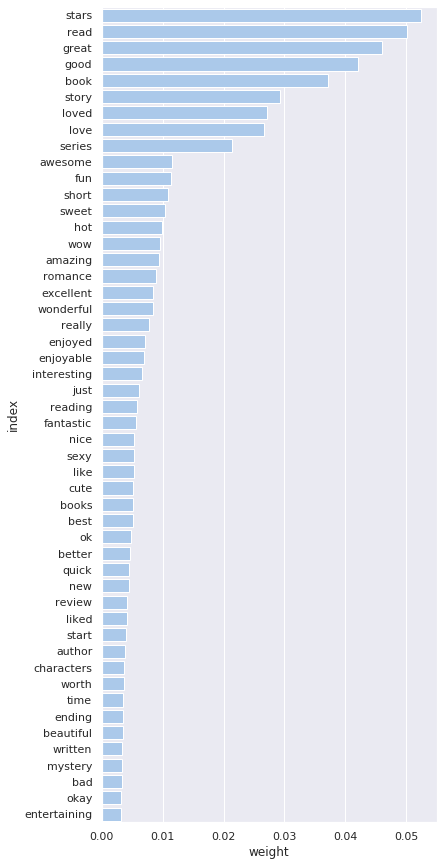

In [0]:


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset


# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="weight", y="index", data=top50_weight_words,
            label="Weight", color="b")

###Preprocessing the data

In [0]:
### Defining the basics:

train, val = train_test_split(processed_reviews, train_size=0.80, test_size=0.20,
                              stratify=processed_reviews['overall'], random_state=42)

train.shape, val.shape

((163103, 508), (40776, 508))

In [0]:
### Set the variables.

target ='overall'

features = train.columns.drop(target,'reviewID')

X_train = train[features]
X_val = val[features]

y_train = train[target]
y_val = val[target]

In [0]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((163103, 507), (163103,), (40776, 507), (40776,))

In [0]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [0]:
X_train = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_val = pd.DataFrame(X_val_scaled,columns=X_train.columns) 

In [0]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((163103, 507), (163103,), (40776, 507), (40776,))

In [0]:
X_train

,verified,reviewerID,asin,unixReviewTime,vote,image,reviewyear,reviewmonth,reviewday,season,len_summary,polarity_sum,subjectivity_sum,polarity_rT,subjectivity_rT,len_reviewText,steamy,potential,vulgar,historical,thriller,poor,home,shifter,character,heartwarming,intense,extremely,tried,romance,depressing,interesting,dull,sad,unfinished,super,zombie,loving,sample,badly,...,idea,continuation,summer,epic,decent,follow,charming,dumb,ok,arc,excellent,type,let,strange,cool,far,new,world,sexy,god,got,yawn,outstanding,stories,lost,story,easy,execution,bride,hooked,absolute,crap,real,life,editing,started,sequel,long,wasted,lame
0,0.771240,-1.274815,-1.322328,-1.610659,-0.167452,-0.02452,-1.391526,-0.963222,1.047646,-1.291608,-0.660162,1.098734,0.929596,-0.792067,0.294109,-0.385189,-0.060832,-0.025798,-0.005387,-0.028989,-0.034346,-0.018114,-0.031808,-0.046102,-0.032799,-0.033688,-0.036159,-0.006284,-0.01052,-0.139012,-0.004729,-0.094793,-0.011294,-0.025081,-0.006242,-0.0433,-0.006457,-0.041397,-0.006472,-0.006444,...,-0.019978,-0.018853,-0.025618,-0.008926,-0.034432,-0.026852,-0.022856,-0.006449,-0.07578,-0.028069,-0.103328,-0.00705,-0.010794,-0.009431,-0.008797,-0.042792,-0.093687,-0.052043,-0.095489,-0.011438,-0.034613,-0.005366,-0.036209,-0.072163,-0.011716,-0.249234,-0.064653,-0.009858,-0.014368,-0.03381,-0.004905,-0.007131,-0.051588,-0.064862,-0.027213,-0.019326,-0.031982,-0.03587,-0.005962,-0.009255
1,0.771240,-1.274766,-1.322267,0.660266,-0.167452,-0.02452,0.758958,-0.672726,1.387044,-1.291608,-0.660162,-0.844408,-1.282018,1.923838,2.957549,-0.669619,-0.060832,-0.025798,-0.005387,-0.028989,-0.034346,-0.018114,-0.031808,-0.046102,-0.032799,-0.033688,-0.036159,-0.006284,-0.01052,-0.139012,-0.004729,-0.094793,-0.011294,-0.025081,-0.006242,-0.0433,-0.006457,-0.041397,-0.006472,-0.006444,...,-0.019978,-0.018853,-0.025618,-0.008926,-0.034432,-0.026852,-0.022856,-0.006449,-0.07578,-0.028069,-0.103328,-0.00705,-0.010794,-0.009431,-0.008797,-0.042792,-0.093687,-0.052043,-0.095489,-0.011438,-0.034613,-0.005366,-0.036209,-0.072163,-0.011716,-0.249234,-0.064653,-0.009858,-0.014368,-0.03381,-0.004905,-0.007131,-0.051588,-0.064862,-0.027213,-0.019326,-0.031982,-0.03587,-0.005962,-0.009255
2,0.771240,-1.274716,-1.322205,-0.818850,-0.167452,-0.02452,-0.674698,-0.672726,0.821380,-1.291608,-0.378481,0.612948,0.929596,-0.569870,-0.759980,0.378708,-0.060832,-0.025798,-0.005387,-0.028989,-0.034346,-0.018114,-0.031808,-0.046102,-0.032799,-0.033688,-0.036159,-0.006284,-0.01052,-0.139012,-0.004729,-0.094793,-0.011294,-0.025081,-0.006242,-0.0433,-0.006457,-0.041397,-0.006472,-0.006444,...,-0.019978,-0.018853,-0.025618,-0.008926,-0.034432,-0.026852,-0.022856,-0.006449,-0.07578,-0.028069,-0.103328,-0.00705,-0.010794,-0.009431,-0.008797,-0.042792,-0.093687,-0.052043,-0.095489,-0.011438,-0.034613,-0.005366,-0.036209,-0.072163,-0.011716,-0.249234,-0.064653,-0.009858,-0.014368,-0.03381,-0.004905,-0.007131,-0.051588,-0.064862,-0.027213,-0.019326,-0.031982,-0.03587,-0.005962,-0.009255
3,-1.296612,-1.274667,-1.322143,0.835107,-0.167452,-0.02452,0.758958,0.198763,0.934513,-0.395595,-0.941843,-0.844408,-1.282018,0.289012,0.702224,0.175544,-0.060832,-0.025798,-0.005387,-0.028989,-0.034346,-0.018114,-0.031808,-0.046102,-0.032799,-0.033688,-0.036159,-0.006284,-0.01052,-0.139012,-0.004729,-0.094793,-0.011294,-0.025081,-0.006242,-0.0433,-0.006457,-0.041397,-0.006472,-0.006444,...,-0.019978,-0.018853,-0.025618,-0.008926,-0.034432,-0.026852,-0.022856,-0.006449,-0.07578,-0.028069,-0.103328,-0.00705,-0.010794,-0.009431,-0.008797,-0.042792,-0.093687,-0.052043,-0.095489,-0.011438,-0.034613,-0.005366,-0.036209,-0.072163,-0.011716,-0.249234,-0.064653,-0.009858,-0.014368,-0.03381,-0.004905,-0.007131,-0.051588,-0.064862,-0.027213,-0.019326,-0.031982,-0.03587,-0.005962,-0.009255
4,0.771240,-1.274618,-1.322081,-0.740473,-0.167452,-0.02452,-0.674698,-0.091734,-1.667543,-0.395595,-0.660162,1.376325,0.791370,-1.249029,-0.896525,-0.474581,-0.060832,-0.025798,-0.005387,-0.028989,-0.0343

## Step  - LogisticRegressionCV

In [0]:
X_train_lrcv = X_train_scaled 
X_val_lrcv =X_val_scaled  


In [0]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='newton-cg',
                         class_weight='balanced',
                         n_jobs=-1,
                         multi_class='ovr',
                         random_state=42)
    
)

pipeline.fit(X_train_lrcv, y_train)
score = pipeline.score(X_train_lrcv, y_train)
score1 = pipeline.score(X_val_lrcv, y_val)

print(f'Training Accuracy:{score}')
print(f'Validation Accuracy:{score1}')

Training Accuracy:0.5614305071028737
Validation Accuracy:0.5563321561702963


## Step 3 RadomForestClassifier 

In [0]:
X_train_rfc = pd.DataFrame(X_train,columns=X_train.columns)
X_val_rfc = pd.DataFrame(X_val,columns=X_train.columns)




In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=300, max_depth=100, min_samples_split=25)
    
)

pipeline.fit(X_train_rfc, y_train)
score = pipeline.score(X_train_rfc, y_train)
score1 = pipeline.score(X_val_rfc, y_val)

print(f'Training Accuracy:{score}')
print(f'Validation Accuracy:{score1}')

Training Accuracy:0.8070237825177955
Validation Accuracy:0.6782421031979596


In [0]:
dump(pipeline, 'modelrfc.joblib', compress=True)

['modelrfc.joblib']

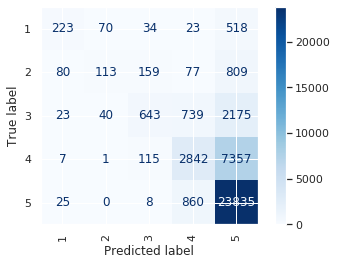

In [0]:
plot_confusion_matrix(pipeline,X_val_rfc,y_val,xticks_rotation='vertical', values_format='.0f', cmap=plt.cm.Blues)
plt.show();

In [0]:
pred_probs = pd.Series(pipeline.predict_proba(X_val_rfc)[:,1])

from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):

  lb = LabelBinarizer()
  lb.fit(y_val)
  y_test = lb.transform(y_val)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)



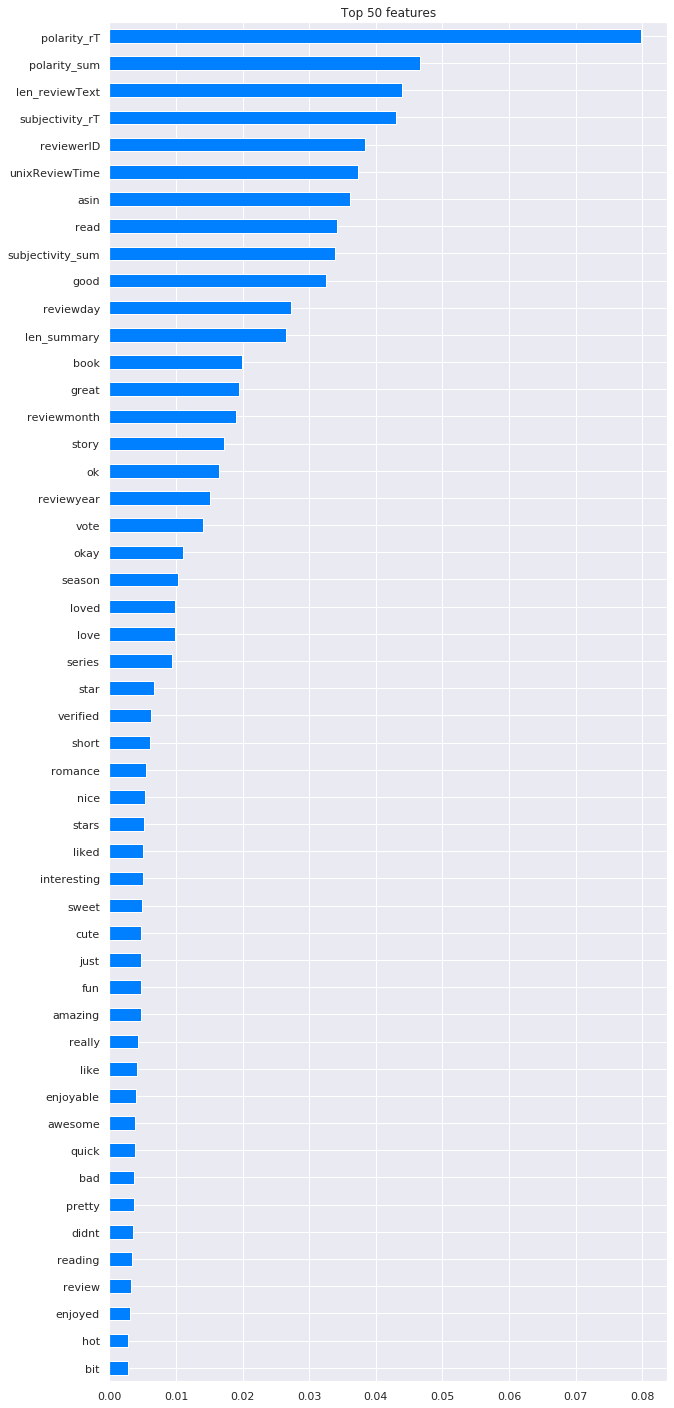

In [0]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train_rfc.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')

importances.sort_values()[-n:].plot.barh(color='#0080FF');

In [0]:
n = 300

features_important = importances.sort_values()[-n:].index

X_train_rfc = pd.DataFrame(X_train_scaled,columns=X_train.columns)[features_important]
X_val_rfc =pd.DataFrame(X_val_scaled,columns=X_train.columns)[features_important]

In [0]:
pipeline = make_pipeline(
    RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=300, max_depth=100, min_samples_split=25)
    
)

pipeline.fit(X_train_rfc, y_train)
score = pipeline.score(X_train_rfc, y_train)
score1 = pipeline.score(X_val_rfc, y_val)

print(f'Training Accuracy:{score}')
print(f'Validation Accuracy:{score1}')

### LGBM classifier 

In [0]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

In [0]:
X_train_lgbm = X_train
X_val_lgbm = X_val

In [0]:
model = LGBMClassifier(objective='multiclass', class_weight='balanced', n_jobs=-1, n_estimators= 300, learning_rate=0.4, num_leaves=1500, max_depth=70  )

model.fit(X_train_lgbm,y_train);



0.7064694918579557

In [0]:
y_pred = model.predict(X_val_lgbm)

accuracy_score(y_val,y_pred)

0.7064694918579557

In [0]:
y_val.shape, y_pred.shape

((40776,), (40776,))

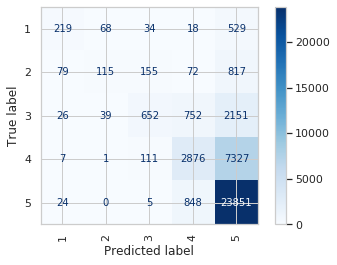

In [0]:
plot_confusion_matrix(pipeline,X_val_rfc,y_val,xticks_rotation='vertical', values_format='.0f', cmap=plt.cm.Blues)
plt.show();

In [0]:
dump(model, 'model.joblib', compress=True)

['model.joblib']

In [0]:
multiclass_roc_auc_score(y_val, y_pred, average="macro")

0.6577396187564224

In [0]:
y_val

57995     4
27538     3
140394    5
125837    5
127450    5
         ..
109639    5
92718     5
189133    5
164858    5
96377     5
Name: overall, Length: 40776, dtype: int64

In [0]:
model.predict(pd.DataFrame(X_val_lgbm.loc[2162,:]).T)

array([4])

# Draft

In [0]:
inv1 = scaler.inverse_transform(X_val_lgbm)
inv1 = pd.DataFrame(inv1,columns=X_val.columns)
inv1
encoder.inverse_transform(pd.DataFrame(inv1)).loc[2162:2162,:]

/usr/local/lib/python3.6/dist-packages/category_encoders/ordinal.py:255: UserWarning: inverse_transform is not supported because transform impute the unknown category -1 when encode reviewerID
  "the unknown category -1 when encode %s" % (col,))
/usr/local/lib/python3.6/dist-packages/category_encoders/ordinal.py:255: UserWarning: inverse_transform is not supported because transform impute the unknown category -1 when encode asin
  "the unknown category -1 when encode %s" % (col,))


,verified,reviewerID,asin,unixReviewTime,vote,image,reviewyear,reviewmonth,reviewday,season,len_summary,polarity_sum,subjectivity_sum,polarity_rT,subjectivity_rT,len_reviewText,steamy,potential,vulgar,historical,thriller,poor,home,shifter,character,heartwarming,intense,extremely,tried,romance,depressing,interesting,dull,sad,unfinished,super,zombie,loving,sample,badly,...,idea,continuation,summer,epic,decent,follow,charming,dumb,ok,arc,excellent,type,let,strange,cool,far,new,world,sexy,god,got,yawn,outstanding,stories,lost,story,easy,execution,bride,hooked,absolute,crap,real,life,editing,started,sequel,long,wasted,lame
2162,0.0,A23G8AS057YY0M,NaN,1.421107e+09,0.0,0.0,2015.0,1.0,13.0,winter,4.0,0.5,0.6,0.204861,0.586111,124.0,0.0,0.0,-3.388132e-21,0.0,0.0,0.0,-1.084202e-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.084202e-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.084202e-19,0.0,0.0,0.0


In [0]:
reviews[reviews['reviewerID']=='A23G8AS057YY0M' ]

,reviewID,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,vote,image,reviewyear,reviewmonth,reviewday,season,len_summary,polarity_sum,subjectivity_sum,polarity_rT,subjectivity_rT,len_reviewText
59425,59425,3,True,A23G8AS057YY0M,B005NB295K,nothing particularly profound but there was so...,good for new christians,1410220800,0,False,2014,9,9,autumn,4,0.418182,0.527273,0.331212,0.681818,32
62041,62041,4,False,A23G8AS057YY0M,B008AWLN24,in this book the author gives us a peek at her...,a good attitude adjustment,1412035200,0,False,2014,9,30,autumn,4,0.700000,0.600000,0.110767,0.439528,90
67281,67281,3,False,A23G8AS057YY0M,B00GBJAOSW,this was a nice wholesome christmas story but ...,wholesome but left me flat,1415318400,0,False,2014,11,7,autumn,5,-0.012500,0.062500,0.150260,0.418229,96
77189,77189,4,False,A23G8AS057YY0M,B00GG9U4UK,i enjoyed this book as i read it i thought the...,an enjoyable christmas read,1421107200,0,False,2015,1,13,winter,4,0.500000,0.600000,0.204861,0.586111,124
126917,126917,4,True,A23G8AS057YY0M,B00A949IKA,this concise outline of napoleons life covers ...,good outline of napoleons life,1448755200,0,False,2015,11,29,autumn,5,0.700000,0.600000,0.262500,0.625000,33


In [0]:
reviews.loc[24223,:]

reviewID                                                        24223
overall                                                             2
verified                                                         True
reviewerID                                              AX9ZL5ZXADR3J
asin                                                       B00F2NMUVM
reviewText          yes its only  but the characters and the situa...
summary                                       not very well developed
unixReviewTime                                             1381622400
vote                                                                0
image                                                           False
reviewyear                                                       2013
reviewmonth                                                        10
reviewday                                                          13
season                                                         autumn
len_summary         